# visualizing the images

In [1]:
# trainer
print("strawberry")
from trustworthai.utils.fitting_and_inference.fitters.basic_lightning_fitter import StandardLitModelWrapper
from trustworthai.utils.fitting_and_inference.get_trainer import get_trainer

# data
from twaidata.torchdatasets_v2.mri_dataset_inram import MRISegmentation3DDataset
from twaidata.torchdatasets_v2.mri_dataset_from_file import MRISegmentationDatasetFromFile, ArrayMRISegmentationDatasetFromFile
from twaidata.mri_dataset_directory_parsers.MSS3_multirater import MSS3MultiRaterDataParser

# packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torchinfo import summary
from tqdm import tqdm
from collections import defaultdict
from natsort import natsorted
import torchmetrics
print("banana")

strawberry
banana


In [2]:
import seaborn as sns
import scipy
from torch.utils.data import ConcatDataset

### Loading Challenge flair t1 mask dataset

In [3]:
ds_name = "Challenge"

In [4]:
model_name = "ssn_ens"
domains_chal = ["training_Singapore", "training_Utrecht", "training_Amsterdam_GE3T", "test_Singapore", "test_Utrecht", "test_Amsterdam_GE3T", "test_Amsterdam_GE1T5", "test_Amsterdam_Philips_VU_PETMR_01"]
    
ds = ConcatDataset([
    MRISegmentation3DDataset("/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/collated", no_labels=False, xy_only=False, domain_name=dn)
    for dn in domains_chal
])


In [5]:
IDs = [v[2] for v in ds]

### Loading Challenge predictions

In [6]:
def load_output_maps(output_maps_dir):
    output_maps_lists = defaultdict(lambda: [])
    for fID in tqdm(os.listdir(output_maps_dir), position=0, leave=True, ncols=100):
        # print(fID)
        # break
        if ".npz" in fID and "model_WMH_samples" not in fID:
            ID = fID.split("_out_maps")[0]
            output_maps_data = np.load(os.path.join(output_maps_dir,fID))
            key_order = natsorted(list(output_maps_data.keys()))
            for key in key_order:
                if key == "seg":
                    continue
                output_maps_lists[ID].append(torch.from_numpy(output_maps_data[key]))
    return output_maps_lists, key_order

In [7]:
# model_name = "SSN_Ens_Mean"
output_maps = {}
for model_name in ["nnunet/nnunetSsnEns2D", "nnunet/nnunet2D"]:
    output_maps_dir = f"/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/training/{model_name}/"
    out_maps_training, key_order = load_output_maps(output_maps_dir)
    
    output_maps_dir = f"/home/s2208943/preprocessed_data/WMHChallenge_InterRaterData/output_maps/test/{model_name}/"
    out_maps_test, key_order = load_output_maps(output_maps_dir)
    output_maps[model_name] = (out_maps_training | out_maps_test)

100%|█████████████████████████████████████████████████████████████| 110/110 [00:17<00:00,  6.46it/s]


### Loading the Fazekas Categories

In [8]:
from trustworthai.journal_run.new_MIA_fazekas_and_QC.dataset_setup import *

In [9]:
cvd_data, adni_data, challenge_data, mss3_data = load_spreadsheets(include_MSS3=True)

challenge shapes before and after cleanup
(175, 1532)
(175, 1465)
cvd shapes before and after cleanup
(250, 1552)
(250, 1402)
adni shapes before and after cleanup
(299, 1544)
(299, 1374)
mss3 shapes before and after cleanup
(68, 46)
(68, 44)


In [10]:
IDs_map = {ID:"_".join(ID.split("_")[1:4]) for ID in IDs}
reverse_IDs_map = {value:key for key, value in IDs_map.items()}

In [11]:
import proplot as pplt
import SimpleITK as sitk

In [12]:
def plot_brain_image_singlesice(ds, IDs, output_maps_ssnens, output_maps_deterministic, target_pID, df, reverse_IDs_map, islice_index, r1=20, r2=10, figtitles=False, save=False, mark_locs=None, extra_title=None):
    IDs = np.array(IDs)
    scan_id = np.where(IDs == reverse_IDs_map[target_pID])[0].item()
    
    nslices = ds[scan_id][0][0].shape[0]
    gap = nslices // 6
    islice = int(gap * (islice_index + 1) + 4)

    fig = pplt.figure(space=0, refwidth='20em')
    axs = fig.subplots(nrows=1, ncols=6)
    axs.format(grid=False, xlocator='null', ylocator='null')
    for ax in axs:
        for spine in ax.spines:
            ax.spines[spine].set_color('none')
            
    flair = ds[scan_id][0][0]
    flair = flair.clone()
    mask = ds[scan_id][0][2]
    flair[mask==0] = flair.min()

    # flair
    axs[0].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')

    # flair + umap ssn ens
    axs[1].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[1].imshow(output_maps_ssnens[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[2].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[2].imshow(output_maps_ssnens[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')  
    
    # flair + umap deterministic
    axs[3].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[3].imshow(output_maps_deterministic[IDs[scan_id]][0][islice][r1:-r1, r2:-r2], alpha=0.7, vmin=0, vmax=0.7, origin='lower') 

    # flair + ssn ens
    axs[4].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    axs[4].imshow(output_maps_deterministic[IDs[scan_id]][1][islice][r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Greens', origin='lower')
    
    # flair + GT
    axs[5].imshow(flair[islice][r1:-r1, r2:-r2], cmap='gray', vmin=-3, vmax=3, origin='lower')
    if ds[scan_id][1].shape[0] == 1:
        axs[5].imshow((ds[scan_id][1][0] == 1).clip(0, 1)[islice, r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Blues', origin='lower')
    else:
        axs[5].imshow(((ds[scan_id][1][0] == 1) + (ds[scan_id][1][1] == 1) + (ds[scan_id][1][2] == 1)).clip(0, 1)[islice, r1:-r1, r2:-r2] > 0.5, alpha=0.7, vmin=0, vmax=1, cmap='Blues', origin='lower')
    
    
    if figtitles:
        # axs[0].set_title("FLAIR", fontweight='bold')
        axs[1].set_title("SSN-Ens UQ map", fontweight='bold')
        axs[2].set_title("SSN-Ens WMH seg.", fontweight='bold')
        axs[3].set_title("SEnt UQ map", fontweight='bold')
        axs[4].set_title("SEnt WMH seg.", fontweight='bold')
        axs[5].set_title("GT WMH", fontweight='bold')
        axs.format(titleloc='lc', titleborder=False, fontsize=13)
        
    if mark_locs is not None:
        for i, mark in enumerate(mark_locs):
            axs[-1].scatter(mark[0], mark[1], marker=4, s=100, c='yellow')
            axs[-1].scatter(mark[0]+8, mark[1], marker='s', s=80, c='yellow')
            axs[-1].scatter(mark[0]+8, mark[1], marker=f'${i+1}$', s=60, c='black')

    if save:
        if extra_title is None:
            extra_title = ""
        plt.savefig(f"images/challenge seg_example_{target_pID}_{islice}{extra_title}", dpi=200)
    plt.show()

In [13]:
# for iid in reverse_IDs_map.keys():
#     print("----\n", iid)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=0, figtitles=True)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=1, figtitles=False)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2, figtitles=False)

In [14]:
# for iid in reverse_IDs_map.keys():
#     if 'singapore' in iid.lower() or 'utrecht' in iid.lower():
#         continue
#     print("----\n", iid)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2, figtitles=True)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.2, figtitles=False)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.7, figtitles=False)

In [15]:
# for iid in reverse_IDs_map.keys():
#     if 'utrecht' not in iid.lower():
#         continue
#     print("----\n", iid)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=1, figtitles=True)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2, figtitles=False)
#     plot_brain_image_singlesice(ds, IDs, output_maps['ssn_ens'], output_maps['deterministic'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=3, figtitles=False)

In [16]:
# output_maps['nnunet/deterministic']['training_Utrecht_11']

In [17]:
# output_maps['nnunet/deterministic'].keys()#['Amsterdam_GE3T_137']

Amsterdam_GE3T_137


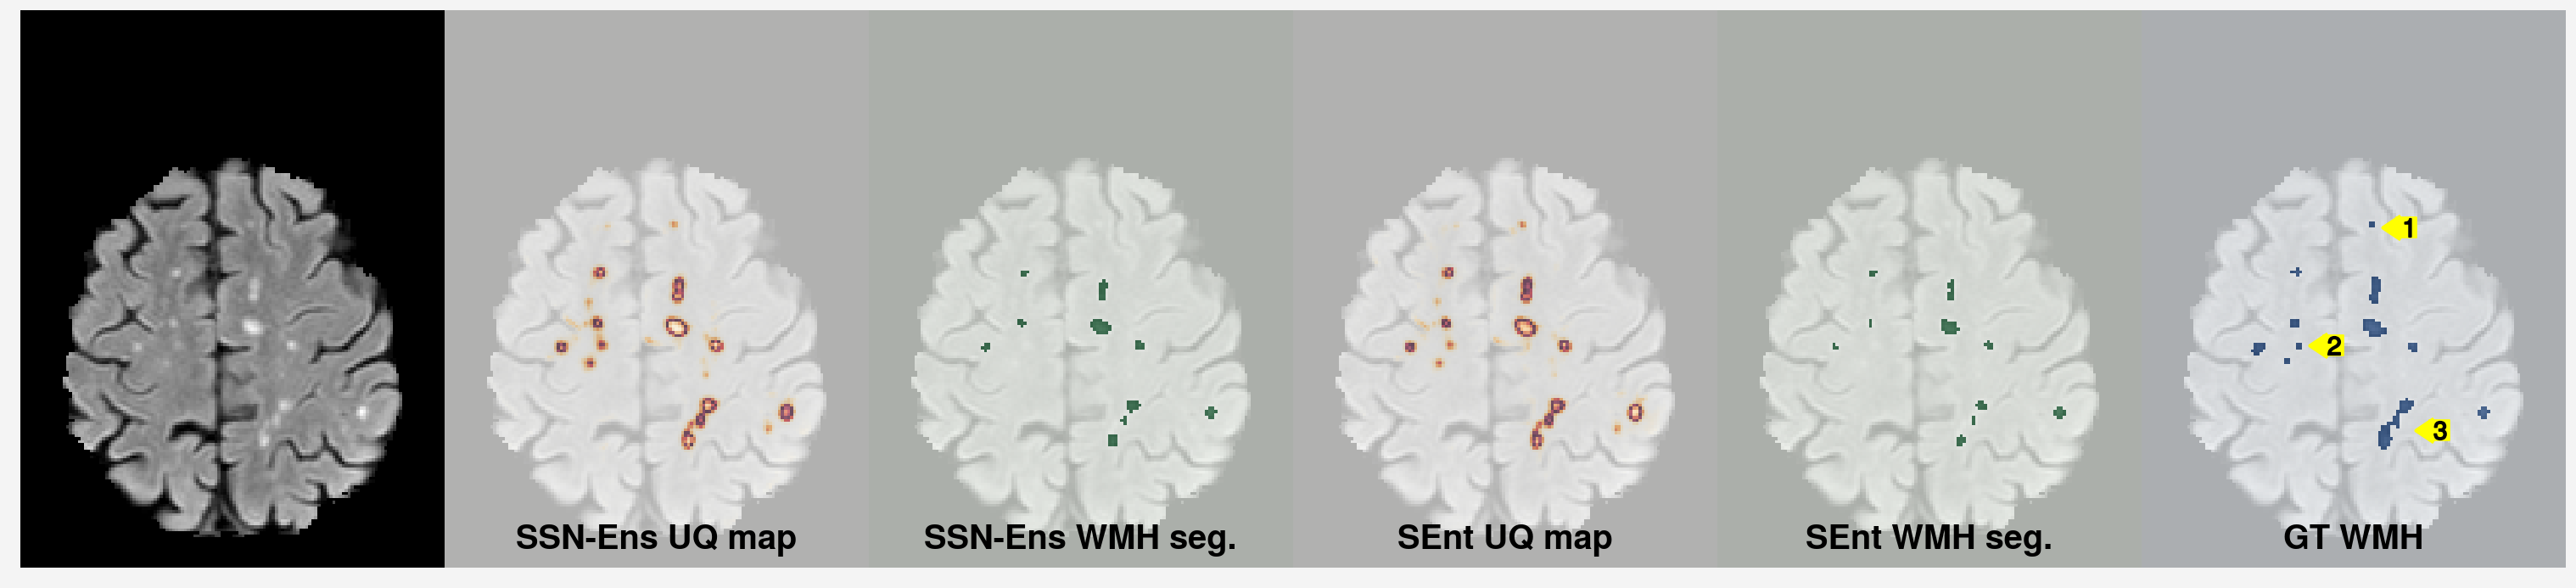

In [18]:
iid = 'Amsterdam_GE3T_137'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=3, figtitles=True,
                           mark_locs=[[79, 112], [55, 73], [90, 45]], save=True) 

Amsterdam_GE3T_115


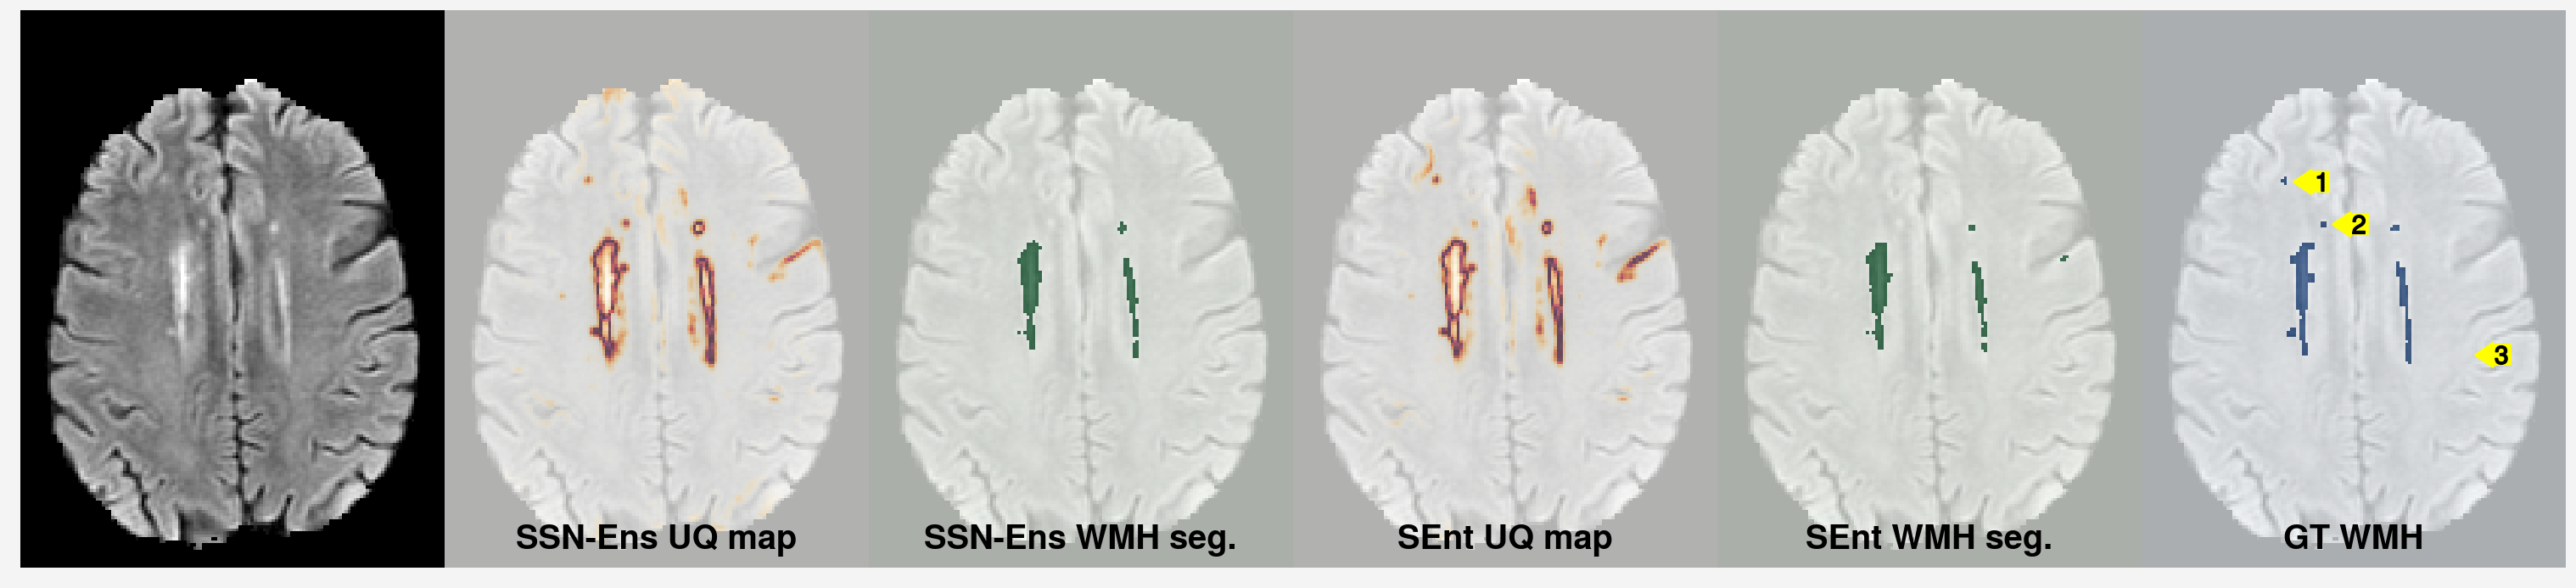

In [19]:
iid = 'Amsterdam_GE3T_115'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=3, figtitles=True,
                           mark_locs=[[50, 127], [63, 113], [110, 70]], save=True)

Amsterdam_GE3T_109


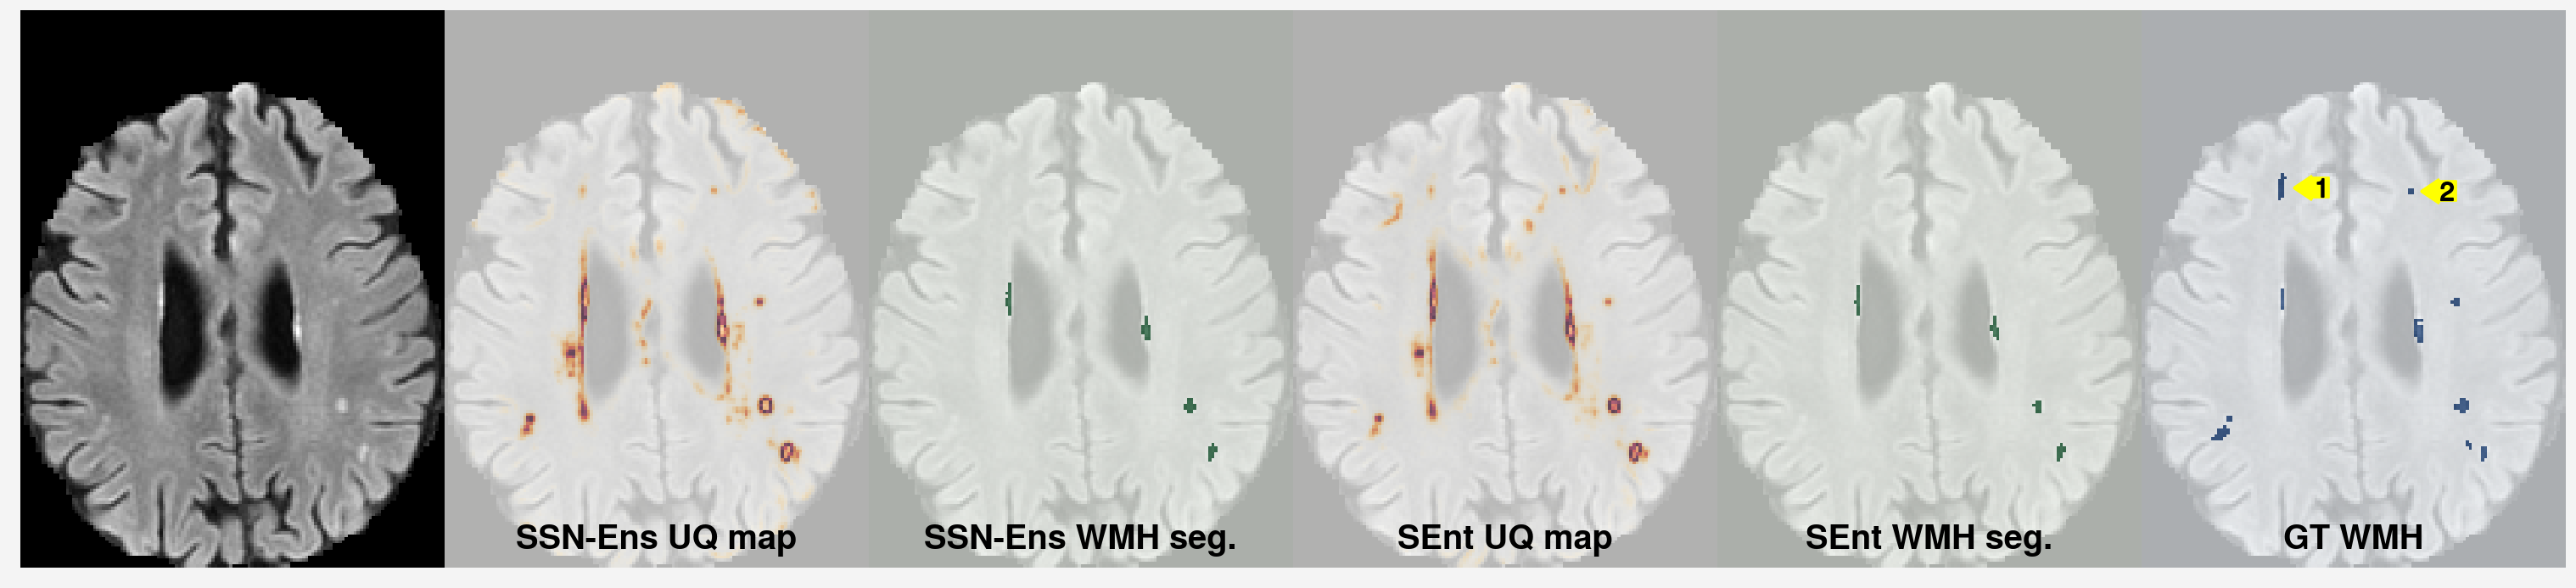

In [20]:
iid = 'Amsterdam_GE3T_109'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.8, figtitles=True,
                           mark_locs=[[50, 125], [92, 124]], save=True)

Amsterdam_GE3T_137


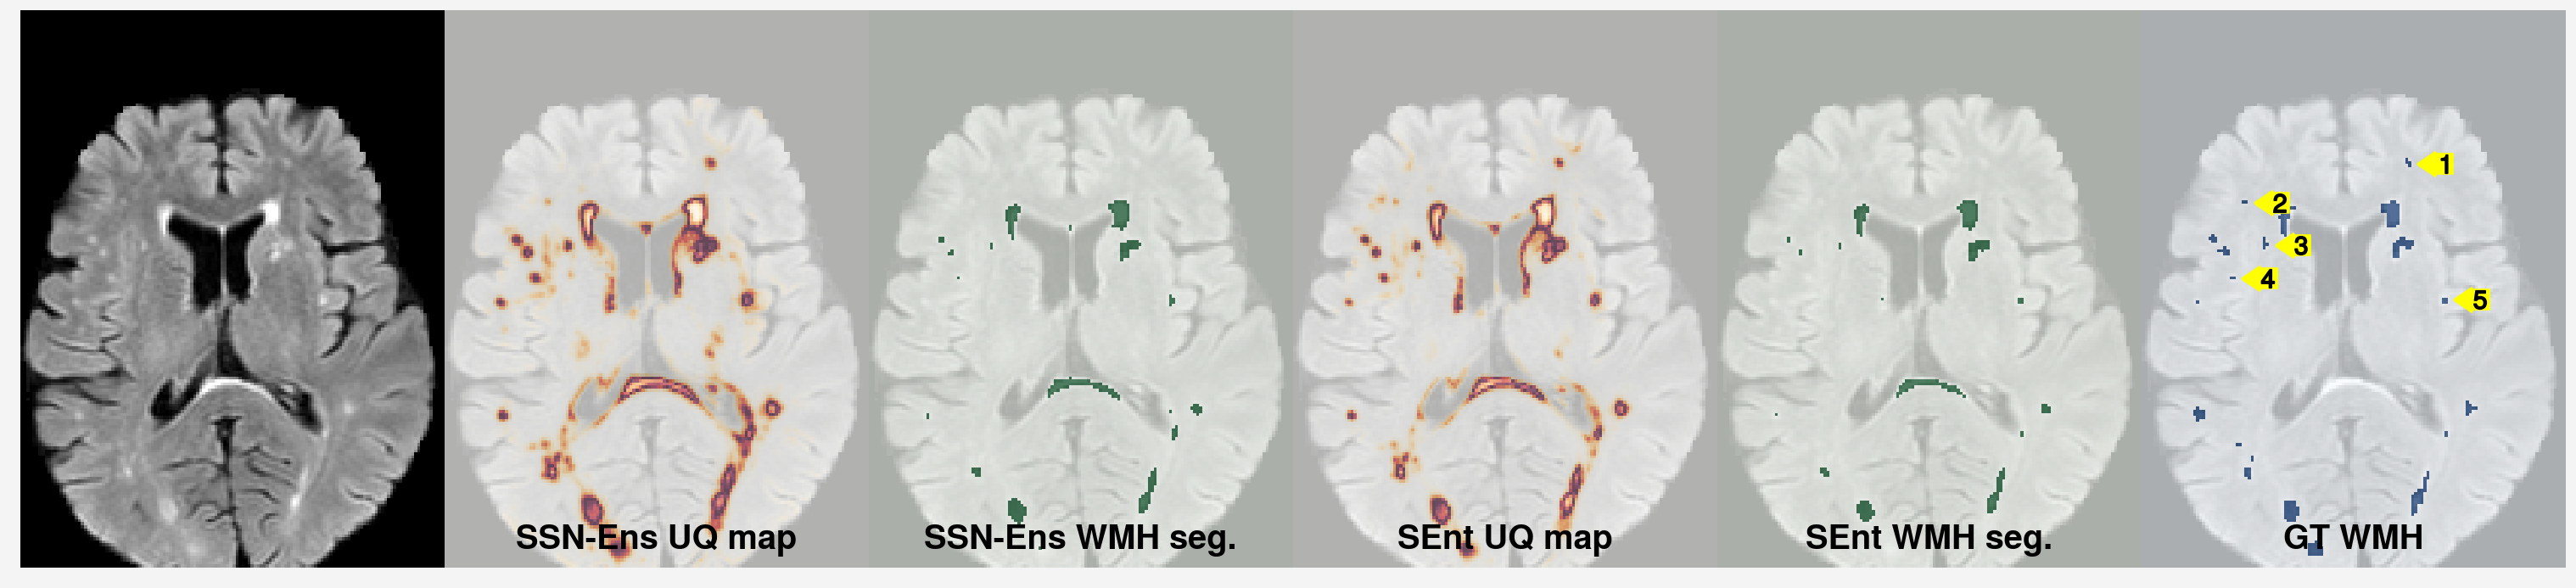

In [21]:
iid = 'Amsterdam_GE3T_137'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.2, figtitles=True,
                           mark_locs=[[91, 133], [37, 120], [44, 106], [33, 95], [103, 88]], save=True)

Utrecht_29


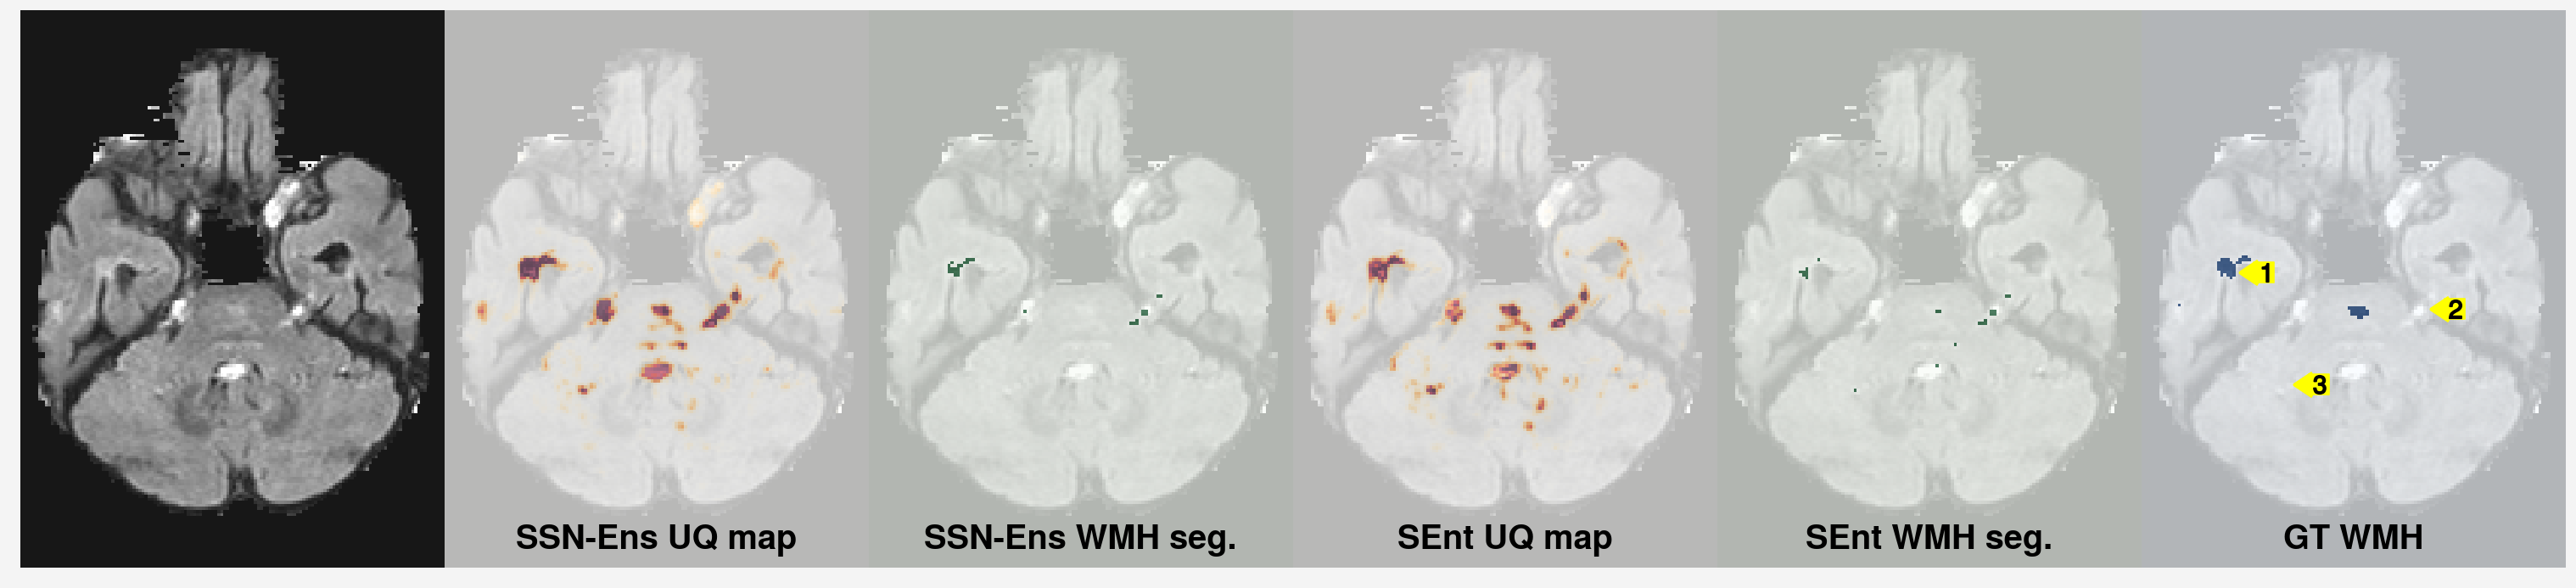

In [22]:
iid = 'Utrecht_29'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=0, figtitles=True,
                           mark_locs=[[32, 97], [95, 85], [50, 60]], save=True)

Singapore_65


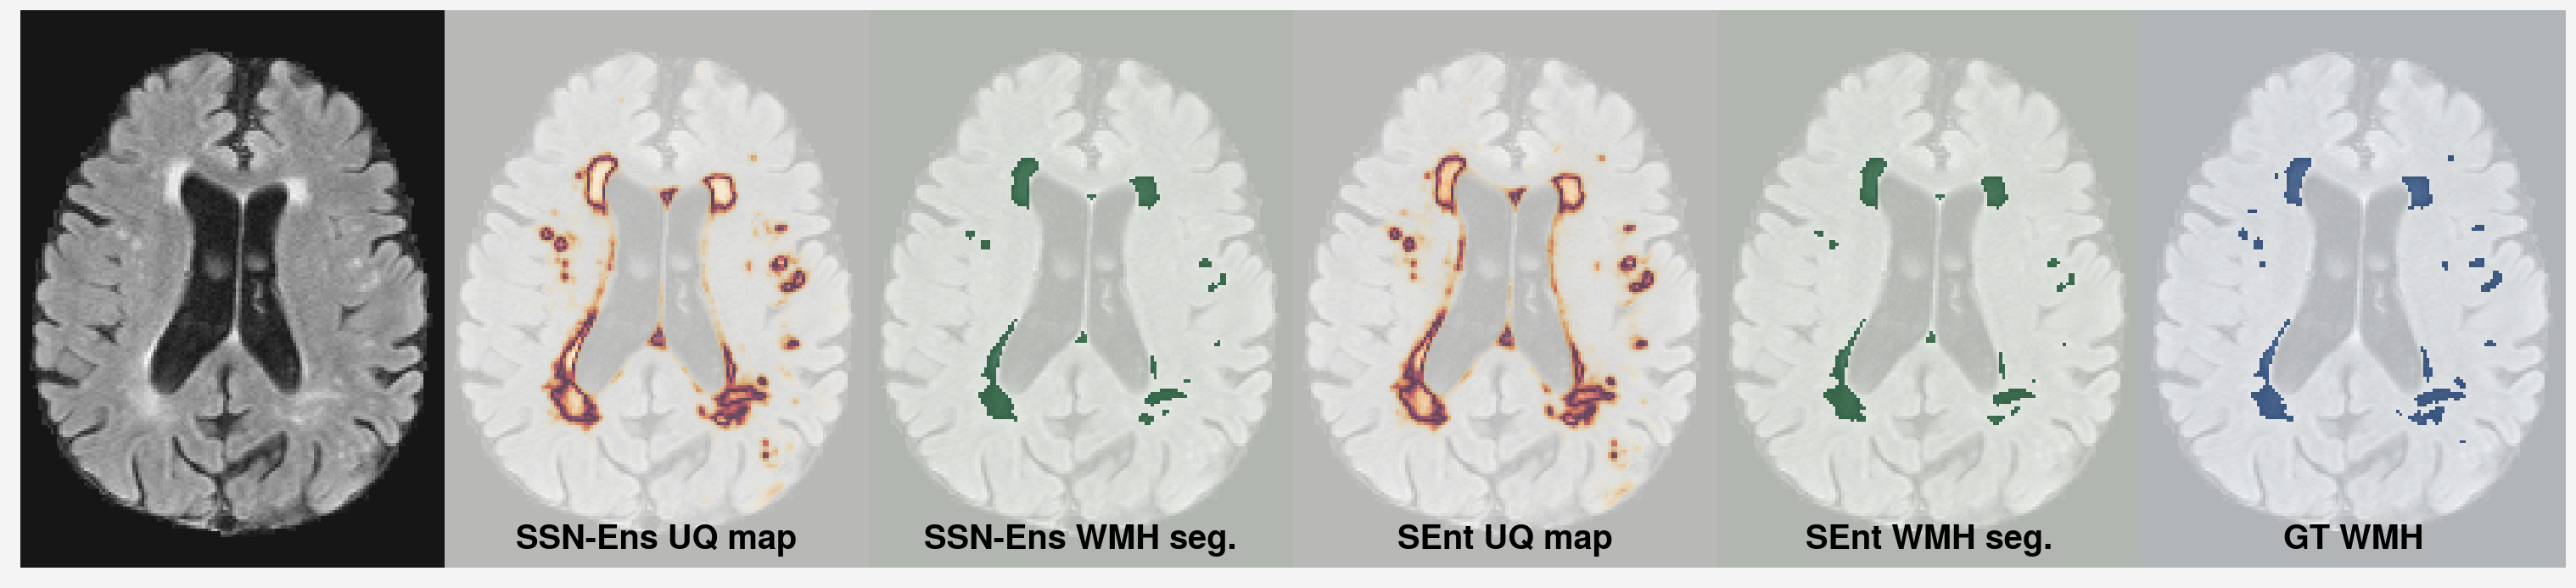

for this image, simply comment that even when both methods identify all lesions, genuine missed lesions have a higher uncertainty level in SSN-Ens ens, i.e yielding a better calibrated uncerrtainty map that is easier to threshold, with SSN-Ens uncertain regions more often pertain to increases intensities in White Matter seen in the image


In [23]:
iid = 'Singapore_65'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2, figtitles=True, save=True)
print("for this image, simply comment that even when both methods identify all lesions, genuine missed lesions have a higher uncertainty level in SSN-Ens ens, i.e yielding a better calibrated uncerrtainty map that is easier to threshold, with SSN-Ens uncertain regions more often pertain to increases intensities in White Matter seen in the image")

Singapore_64


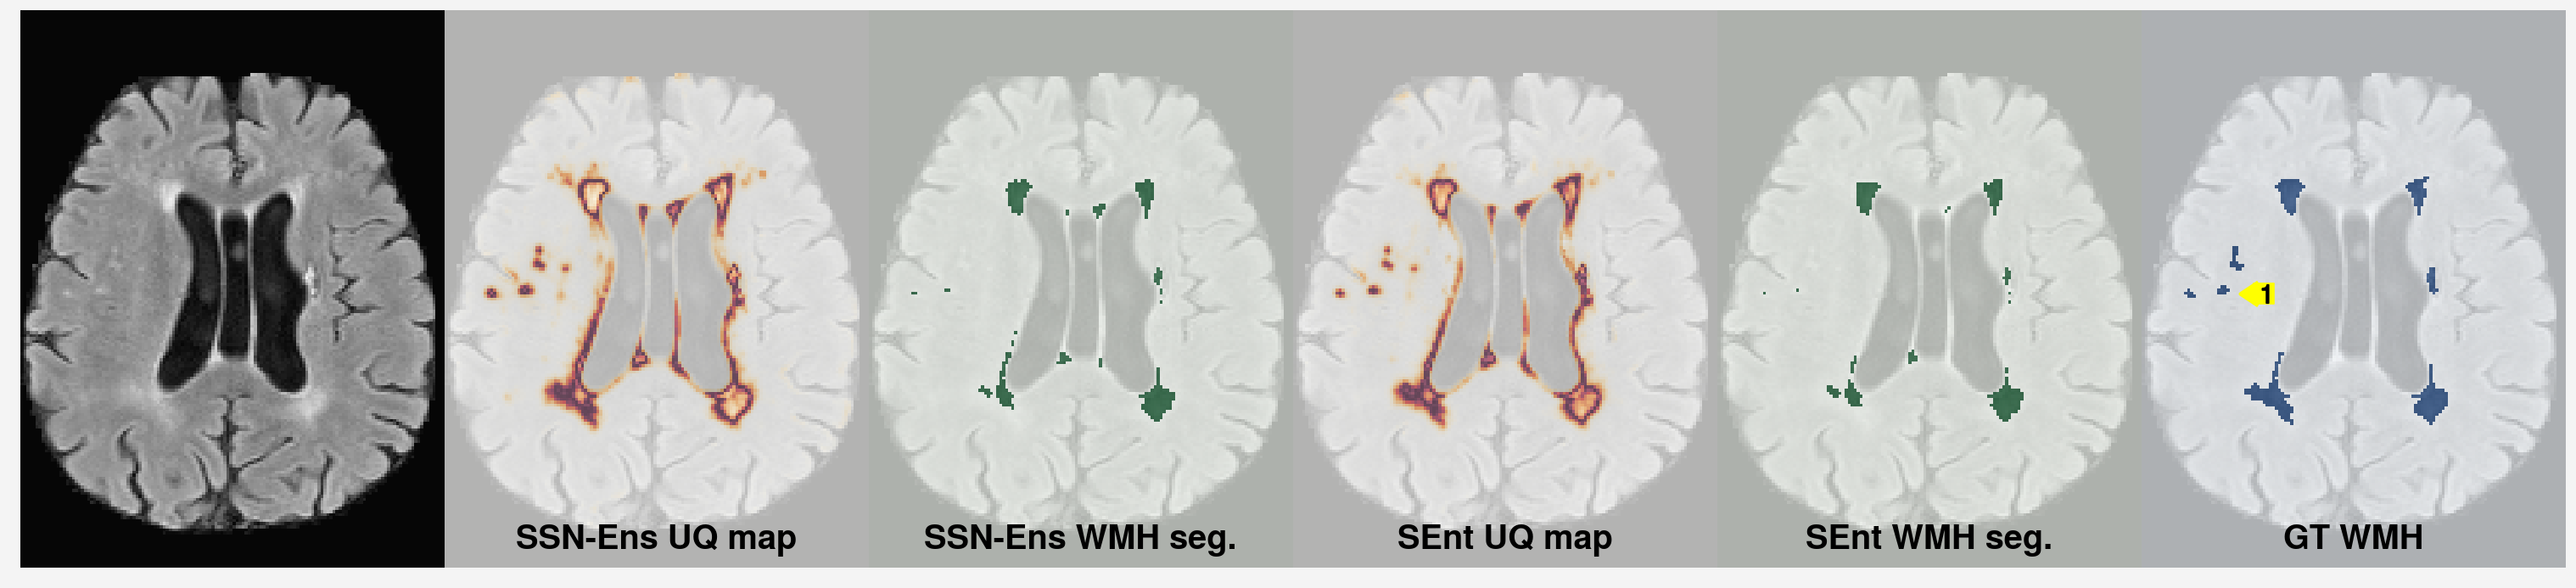

In [24]:
iid = 'Singapore_64'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2, figtitles=True,
                           mark_locs=[[32, 90]], save=True)

Amsterdam_Philips_VU


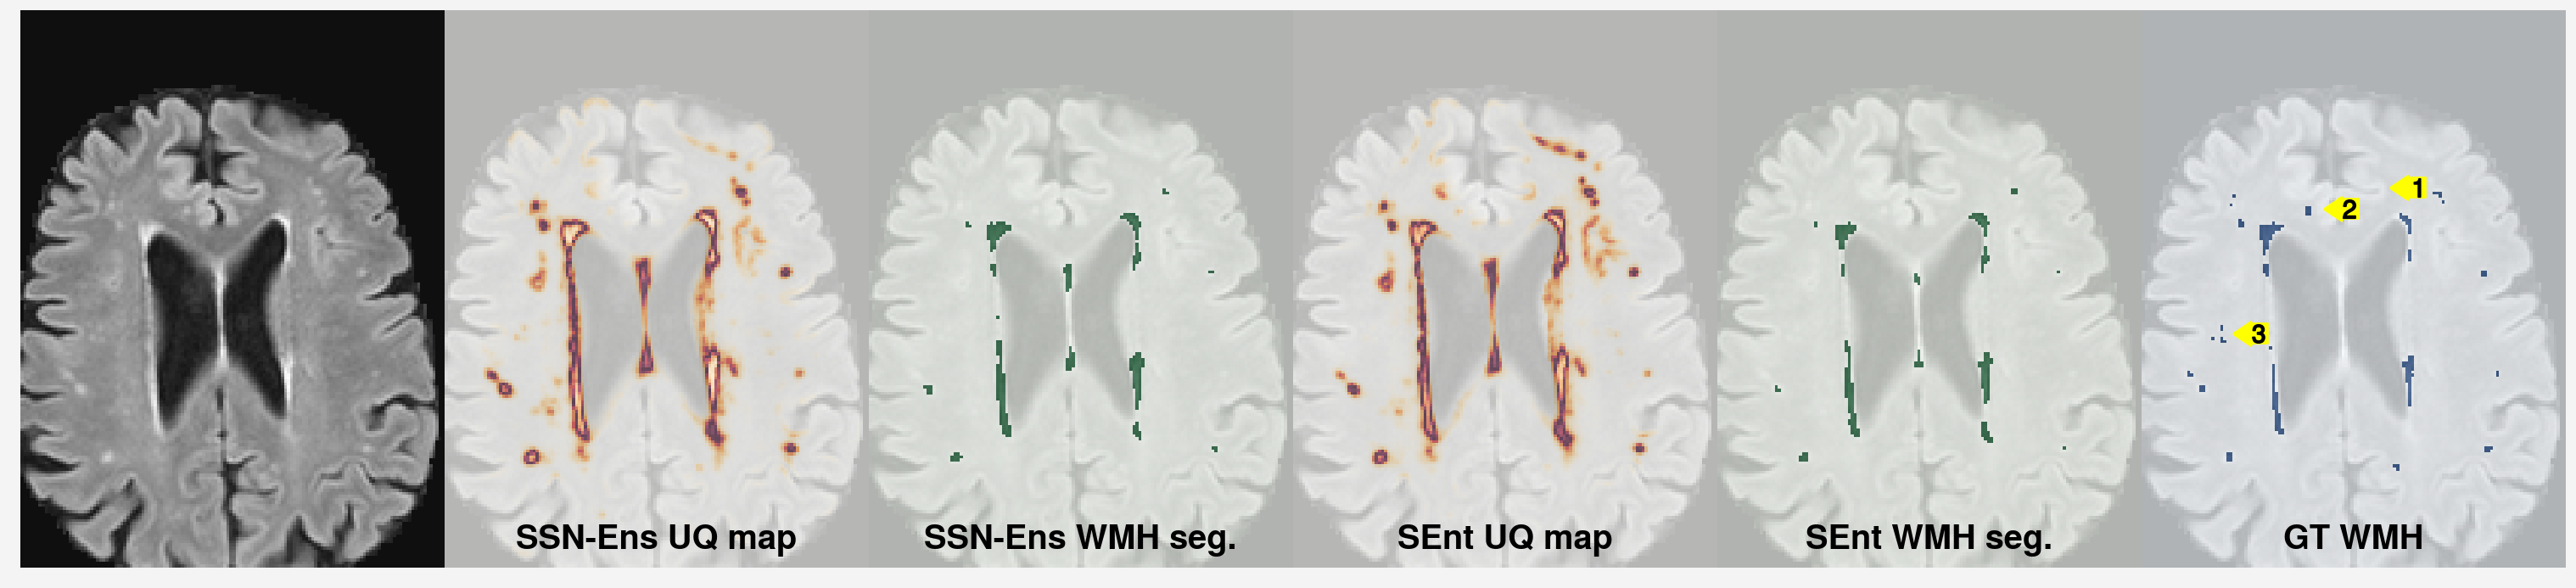

while SSN-Ens in general appears more uncertain in some images, this isn't always the case, e.g here we see a lesion that is certain in SSN-Ens and uncertain in SEnt even though it is correct
also talk about the three WMH in the right hemisphere, I don't need to mark them up


In [25]:
iid = 'Amsterdam_Philips_VU'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.5, figtitles=True,
                           mark_locs=[[82, 125], [60, 118], [30, 77]], save=True)
print("while SSN-Ens in general appears more uncertain in some images, this isn't always the case, e.g here we see a lesion that is certain in SSN-Ens and uncertain in SEnt even though it is correct")
print("also talk about the three WMH in the right hemisphere, I don't need to mark them up")

Amsterdam_Philips_VU


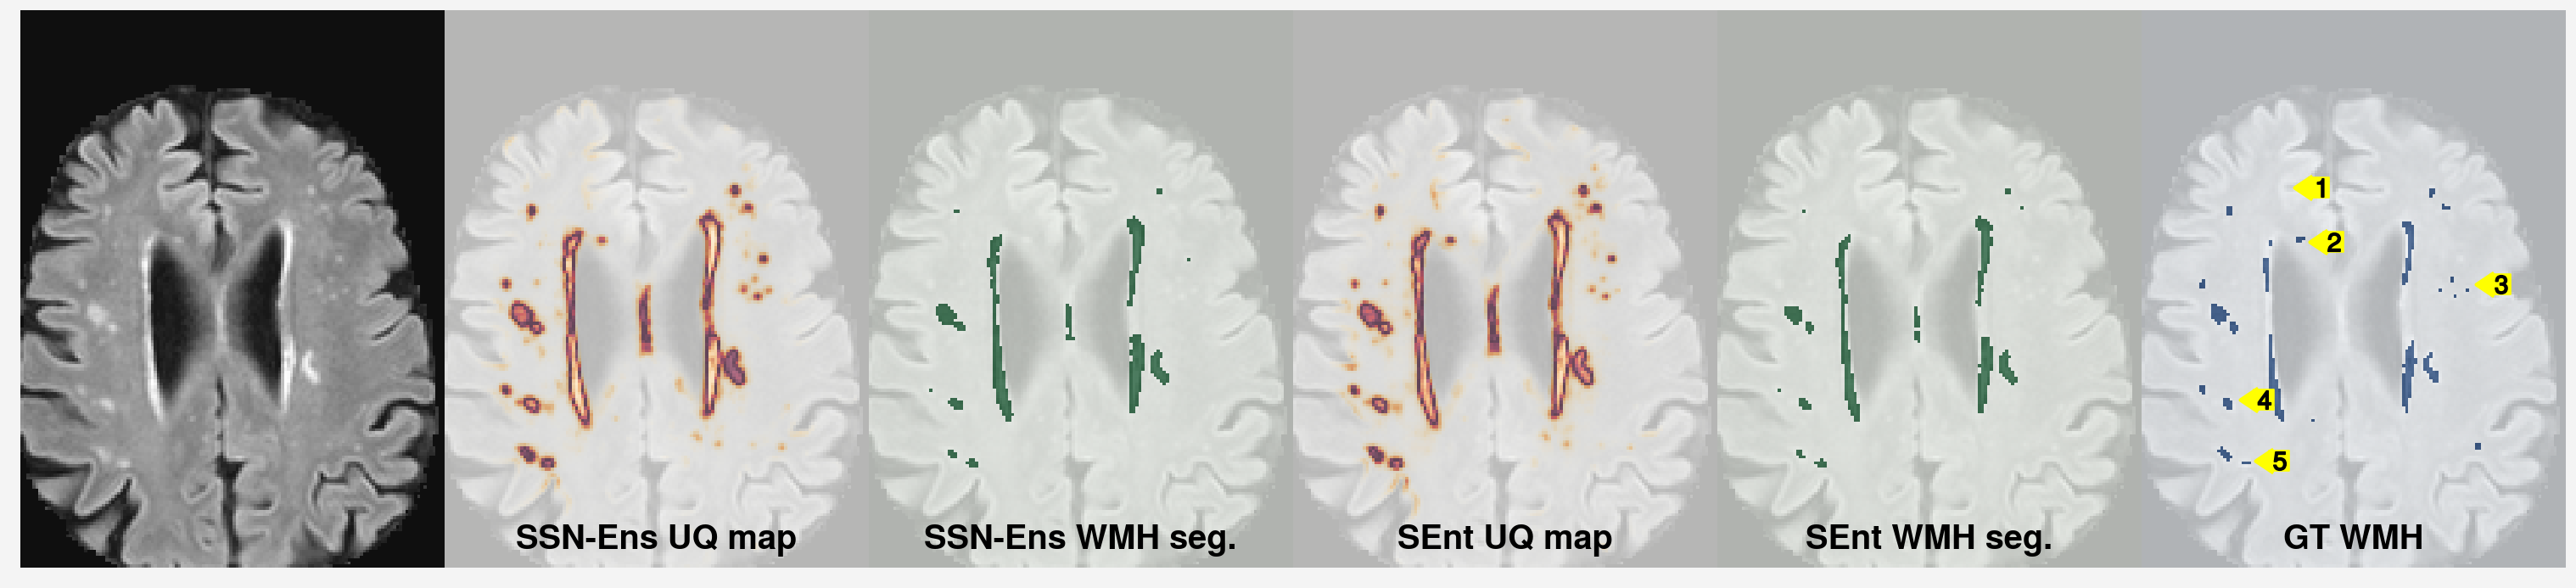

just talk about how SSN-Ens identifies everything but also nuicance gray matter, and does just look like it is highlighting 'more bright stuff', however, notably, the model is less uncertain around correctly identified lesions


In [26]:
iid = 'Amsterdam_Philips_VU'
print(iid)
plot_brain_image_singlesice(ds, IDs, output_maps['nnunet/nnunetSsnEns2D'], output_maps['nnunet/nnunet2D'], iid, challenge_data['ssn_ens'], reverse_IDs_map, islice_index=2.6, figtitles=True,
                           mark_locs=[[50, 125], [55, 107], [110, 93], [32, 55], [37, 35]], save=True, extra_title="no_2")
print("just talk about how SSN-Ens identifies everything but also nuicance gray matter, and does just look like it is highlighting 'more bright stuff', however, notably, the model is less uncertain around correctly identified lesions")